In [423]:
import json
import pandas as pd

In [424]:
with open('data_challenge_outputv1.json', 'r') as f:
    data = json.load(f)
df = pd.DataFrame(data)

In [425]:
df.head()

,change_ts,component_name,component_type,location,status
0,1514764800000,COMPONENT000000001,component_3,GH9CV_00_03,in progress
1,1514764800000,COMPONENT000000002,component_3,GH9CV_00_03,in progress
2,1514764800000,COMPONENT000000003,component_3,GH9CV_00_03,in progress
3,1514764800000,COMPONENT000000004,component_3,GH9CV_00_03,in progress
4,1514764800000,COMPONENT000000005,component_3,GH9CV_00_03,in progress


In [426]:
df= df.drop_duplicates(subset=None, keep='first', inplace=False)# Remove Duplicate Rows

I will rename the machines for easier interpretation as follow:

GH9CV_00_03, -> M1
TG6IA_00_02, -> M2
YBSFJ_00_01, -> M3
VUFVH_00_00, -> M4
JX3UO_01_01, -> M5
5YU1V_01_02, -> M6
MRX5B_01_00, -> M7
ZZU3X_02_00, -> M8
ZAENM_02_01, -> M9 
HUX1L_02_02, -> M10 
29MSJ_03_01, -> M11 
B57X3_03_00, -> M12
7EFLP_03_02, -> M13
assembly room

In [427]:
df= df.replace({'location' : { 'GH9CV_00_03' : 'M1', 'TG6IA_00_02' : 'M2', 'YBSFJ_00_01' : 'M3',
                         'VUFVH_00_00' : 'M4', 'JX3UO_01_01' : 'M5', '5YU1V_01_02' : 'M6',
                         'MRX5B_01_00' : 'M7', 'ZZU3X_02_00' : 'M8', 'ZAENM_02_01' : 'M9',
                         'HUX1L_02_02' : 'M10', '29MSJ_03_01' : 'M11', 'B57X3_03_00' : 'M12',
                          '7EFLP_03_02' : 'M13'}})

In [428]:
df['date'] = pd.to_datetime(df['change_ts'],unit='ms')# Convert epoch timestamp to human readable date

In [429]:
import datetime
# create 'timediff' column which calculates the time elapsed for each individual component since last log (in minutes)
df= df.assign(timediff=df.sort_values('date', ascending=False).
          groupby(['component_name']).date.diff(-1).fillna(0)) 
df['timediff'] = df['timediff'].dt.total_seconds().div(3600)



In [430]:
# create 'origin' column which indicates the previous logged location of the component
df= df.assign(origin=df.sort_values('date', ascending=True).groupby(['component_name']).location.shift(1).fillna(0))

In [431]:
# create 'duration' column which based on the next log determines the duration of the current log (in minutes)
df= df.assign(duration= df.sort_values('date', ascending=True).
          groupby(['component_name']).timediff.shift(-1)) 

In [433]:
kiko= df.component_name[df['status'] == 'complete']
df[df['component_name'].isin(kiko)].groupby('component_name').timediff.sum().describe()
#kiko.sort_values()

count    8604.000000
mean     1180.044513
std       759.966368
min        10.612500
25%       558.237083
50%      1102.759444
75%      1652.281597
max      3205.720278
Name: timediff, dtype: float64

In [491]:
output= df.groupby(['component_type','component_name']).timediff.sum().reset_index()
output.groupby('component_type').describe()

timediff                                                    \
                  count        mean         std  min       25%        50%   
component_type                                                              
component_0     14413.0  665.883380  811.062311  0.0  2.475000   3.337222   
component_1      1866.0  457.258554  554.025879  0.0  9.351389  97.430694   
component_2      7059.0  461.844779  586.746794  0.0  3.602083  24.415000   
component_3      9896.0  775.555695  890.476035  0.0  2.196389  40.378333   

                                          
                        75%          max  
component_type                            
component_0     1348.659722  2881.194444  
component_1      897.973472  1702.603056  
component_2      919.283056  2182.405833  
component_3     1495.334653  3205.720278

In [ ]:
output= df.groupby(['component_type','component_name']).timediff.sum().reset_index()
output.groupby('component_type').describe()

In [435]:
print('Number of Total components: ', df['component_name'].nunique())

Number of Total components:  33234


In [437]:
print (df.groupby('component_type')['component_name'].nunique())

component_type
component_0    14413
component_1     1866
component_2     7059
component_3     9896
Name: component_name, dtype: int64


In [438]:
df.groupby(['component_type','status']).component_name.count()

component_type  status     
component_0     complete        2941
                in progress    27106
                waiting        21168
component_1     complete         993
                in progress     6588
                waiting         1851
component_2     complete        3521
                in progress    17667
                waiting         9297
component_3     complete        1149
                in progress    18099
                waiting        16929
Name: component_name, dtype: int64

In [500]:
from IPython.core.display import HTML

a= df.groupby([df['date'].dt.strftime('%m'),'location', 'status']).component_name.nunique().reset_index()
display(HTML(a.to_html()))


,date,location,status,component_name
0,01,M1,in progress,2003
1,01,M10,in progress,388
2,01,M11,in progress,438
3,01,M11,waiting,818
4,01,M12,in progress,597
5,01,M13,in progress,720
6,01,M13,waiting,484
7,01,M2,in progress,384
8,01,M3,in progress,2947
9,01,M4,in progress,1463


In [501]:
# Solution 
import matplotlib.pyplot as plt
%matplotlib inline
df.groupby(['location','status']).duration.mean()

location       status     
M1             in progress       2.197333
M10            in progress       2.270398
M11            in progress       3.397203
               waiting         845.551334
M12            in progress       3.038324
               waiting           0.189722
M13            in progress       3.806281
               waiting           1.053402
M2             in progress       3.885783
M3             in progress       2.515720
M4             in progress       3.595225
M5             in progress       7.690092
               waiting         952.187042
M6             in progress       4.699773
               waiting         901.425687
M7             in progress       3.133351
M8             in progress       2.841196
               waiting        1028.700175
M9             in progress       4.948114
assembly room  complete               NaN
Name: duration, dtype: float64

In [443]:
df.groupby([df['date'].dt.strftime('%m'), 'status', 'component_type'])['component_name'].nunique()
# Note here that 01- January, 02- February, etc...
                 

date  status       component_type
01    complete     component_0        598
                   component_1        202
                   component_2        713
                   component_3        234
      in progress  component_0       2947
                   component_1        384
                   component_2       1463
                   component_3       2011
      waiting      component_0       2937
                   component_1        378
                   component_2       1454
                   component_3       2015
02    complete     component_0        547
                   component_1        184
                   component_2        666
                   component_3        212
      in progress  component_0       4484
                   component_1        527
                   component_2       1982
                   component_3       3330
      waiting      component_0       3924
                   component_1        345
                   component_2       1729


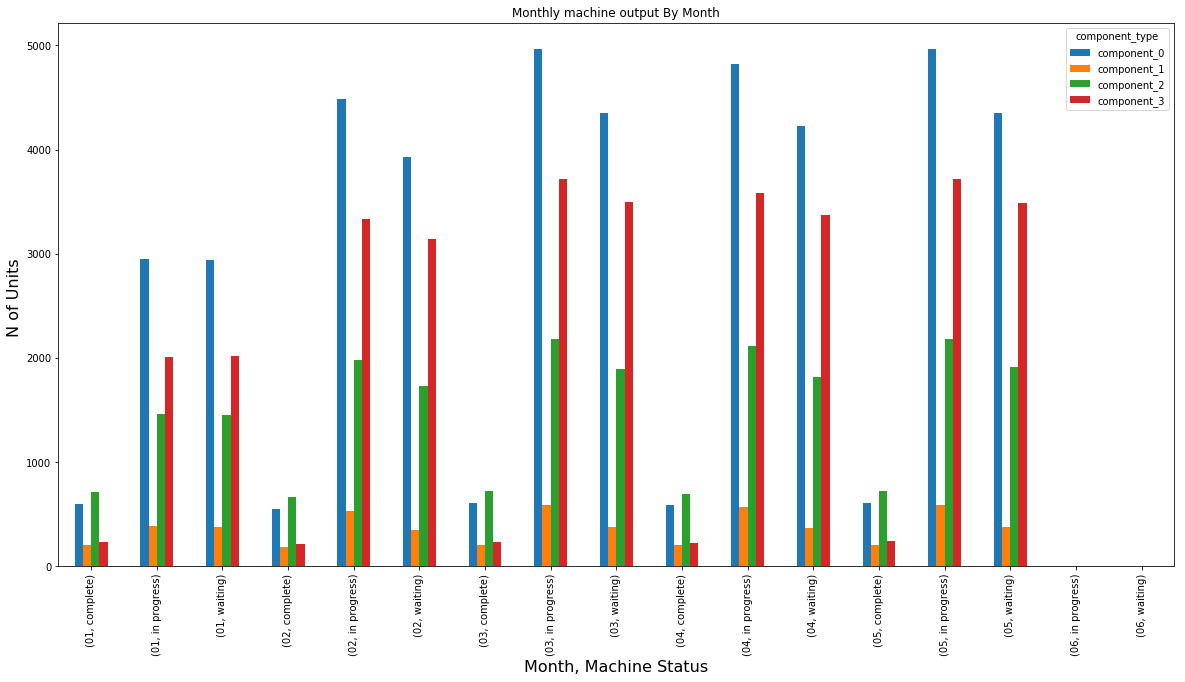

In [480]:
fig = plt.figure()
df.groupby([df['date'].dt.strftime('%m'), 'status', 'component_type'])['component_name'].nunique().unstack().plot.bar(title= 'Monthly machine output By Month', figsize=(20,10))
plt.xlabel('Month, Machine Status', fontsize=16)
plt.ylabel('N of Units ', fontsize=16)